#Timing
The aim of this notebook is to time out the execution of the most relevant alignment algorithms implemented in `MenpoFit`. It the following:

1. Load data
2. Active Template Models
3. Active Appearance Models
4. Constrained Local Models
5. Supervised Descent Method
6. Line-by-line timing

## 1. Load data

This notebook is only concerned about the speed of each alignment algorithms and consequently we will use a very limited amount of training data to build our different models. This will allow users to effectively focus on and compare the speed of each aligning algorithm since the amount of time required to build the different models will be relativetively short.

Note that this notebook does not intend to mesure the accuracy of each method and in fact they are all likely to perform very poorly.

In [16]:
%matplotlib inline

path_to_lfpw = '/vol/atlas/databases/lfpw/trainset/'

In [17]:
import menpo.io as mio

training_images = []

# load landmarked images
for i in mio.import_images(path_to_lfpw, max_images=20, verbose=True):
    
    # crop image
    i = i.crop_to_landmarks_proportion(0.5)

    # convert it to grayscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')

    # append it to the list
    training_images.append(i)

Importing assets: [==========] 100% (20/20) - 00:00:00 remaining


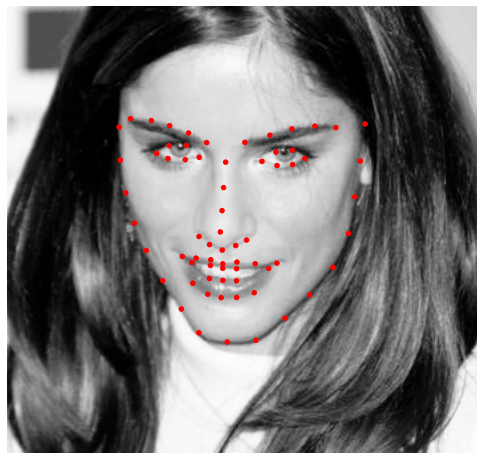

In [18]:
from menpo.visualize import visualize_images

visualize_images(training_images)

We will test the speed of all aligning methods using the `Menpo` built-in images `Takeo` and `BreakingBad`.

In [19]:
takeo = mio.import_builtin_asset.takeo_ppm().as_greyscale()
breakingbad = mio.import_builtin_asset.breakingbad_jpg().as_greyscale()

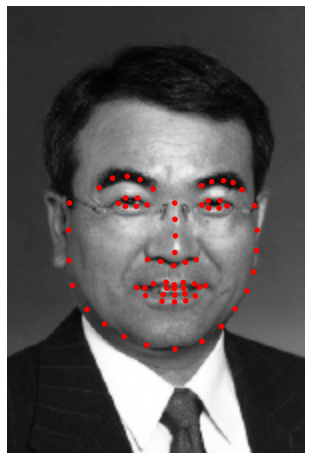

In [20]:
takeo.view_widget()

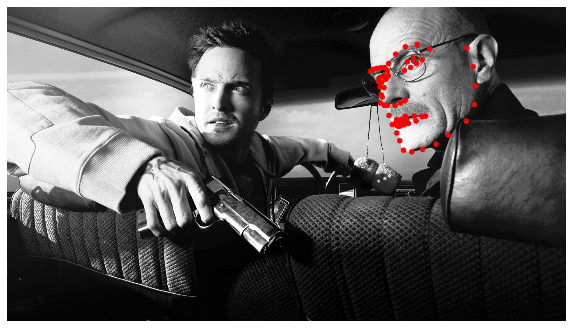

In [21]:
breakingbad.view_widget()

## 2. Active Template Models

Set `ATM` and `LKATMFitter` options. Changing the default values on the next cell will allow the user to explore how different options affect the execution time of different `ATM` fitting algorithms. 

In [22]:
from menpo.feature import no_op, double_igo, hog
from menpofit.transform import DifferentiablePiecewiseAffine, DifferentiableThinPlateSplines
from menpofit.lucaskanade import FA, FC, IC
from menpofit.lucaskanade.residual import SSD, ECC, GaborFourier, GradientImages, GradientCorrelation

# ATM options
features = no_op
transform = DifferentiablePiecewiseAffine
normalization_diagonal = 100
n_levels = 2
downscale = 2
scaled_shape_models = True

# LK ATM Fitter options
algorithm = IC
residual = SSD
n_shape = [3, 12]
max_iters = 20

In [23]:
shapes = [i.landmarks['PTS'].lms for i  in training_images]

### 2.1 Takeo

In [24]:
from menpofit.atm import ATMBuilder
from menpofit.atm import LucasKanadeATMFitter

atm = ATMBuilder(features=features,
                 transform=transform,
                 normalization_diagonal=normalization_diagonal,
                 n_levels=n_levels,
                 downscale=downscale,
                 scaled_shape_models=scaled_shape_models).build(shapes, takeo, verbose=True)
fitter = LucasKanadeATMFitter(atm, algorithm=algorithm, residual=residual, n_shape=n_shape)

gt_shape = takeo.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

- Building model for each of the 2 pyramid levels
  - Level 1: Done
  - Level 2: Done


In [25]:
%timeit fitter.fit(takeo, initial_shape, gt_shape=gt_shape, max_iters=max_iters)

10 loops, best of 3: 78.2 ms per loop


### 2.2 Breaking Bad

In [26]:
from menpofit.atm import ATMBuilder
from menpofit.atm import LucasKanadeATMFitter

atm = ATMBuilder(features=features,
                 transform=transform,
                 normalization_diagonal=normalization_diagonal,
                 n_levels=n_levels,
                 downscale=downscale,
                 scaled_shape_models=scaled_shape_models).build(shapes, breakingbad, verbose=True)
fitter = LucasKanadeATMFitter(atm, algorithm=algorithm, n_shape=n_shape)

gt_shape = breakingbad.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

- Building model for each of the 2 pyramid levels
  - Level 1: Done
  - Level 2: Done


In [27]:
%timeit fitter.fit(breakingbad, initial_shape, gt_shape=gt_shape)

10 loops, best of 3: 180 ms per loop


## 3. Active Apperance Models

Set `AAM` and `LKAAMFitter` options. Changing the default values on the next cell will allow the user to explore how different options affect the execution time of different `AAM` fitting algorithms. 

In [28]:
from menpo.feature import no_op, double_igo, hog
from menpofit.transform import DifferentiablePiecewiseAffine, DifferentiableThinPlateSplines
from menpofit.lucaskanade import AFA, AFC, AIC, SFA, SFC, SIC, PIC

# AAM options
features = double_igo
transform = DifferentiablePiecewiseAffine
normalization_diagonal = 100
n_levels = 2
downscale = 2
scaled_shape_models = True

# LK AAM Fitter options
algorithm = SIC
n_shape = [3, 12]
n_appearance = [25, 50]
max_iters = 20

In [29]:
from menpofit.aam import AAMBuilder
from menpofit.aam import LucasKanadeAAMFitter

aam = AAMBuilder(features=features,
                 transform=transform,
                 normalization_diagonal=normalization_diagonal,
                 n_levels=n_levels,
                 downscale=downscale,
                 scaled_shape_models=scaled_shape_models).build(training_images, verbose=True)
fitter = LucasKanadeAAMFitter(aam, algorithm=algorithm, n_shape=n_shape, n_appearance=n_appearance)

- Normalizing images size: Done
- Building model for each of the 2 pyramid levels
  - Level 1: Done
  - Level 2: Done


### 3.1 Takeo

In [30]:
gt_shape = takeo.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

%timeit fitter.fit(takeo, initial_shape, gt_shape=gt_shape)

1 loops, best of 3: 388 ms per loop


### 3.2 Breaking Bad

In [31]:
gt_shape = breakingbad.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

%timeit fitter.fit(breakingbad, initial_shape, gt_shape=gt_shape)

1 loops, best of 3: 392 ms per loop


## 4. Constrained Local Models

Set `CLM` and `GDCLMFitter` options. Changing the default values on the next cell will allow the user to explore how different options affect the execution time of different `CLM` fitting algorithms. 

In [32]:
from menpo.feature import sparse_hog
from menpofit.gradientdescent import RLMS
from menpofit.clm.classifier import linear_svm_lr

# AAM options
patch_shape = (5, 5)
classifier_trainers = linear_svm_lr
features = sparse_hog
normalization_diagonal = 100
n_levels = 2
downscale = 1.1
scaled_shape_models = True

# LK AAM Fitter options
algorithm = RLMS
n_shape = [3, 12]
max_iters = 20

In [33]:
from menpofit.clm import CLMBuilder
from menpofit.clm import GradientDescentCLMFitter

clm = CLMBuilder(patch_shape=patch_shape,
                 classifier_trainers=classifier_trainers,
                 features=features,
                 normalization_diagonal=normalization_diagonal,
                 n_levels=n_levels,
                 downscale=downscale,
                 scaled_shape_models=scaled_shape_models).build(training_images, verbose=True)
fitter = GradientDescentCLMFitter(clm, algorithm=algorithm, n_shape=n_shape)

- Normalizing images size: Done
- Building model for each of the 2 pyramid levels
  - Level 1: Done
  - Level 2: Done


### 4.1 Takeo

In [34]:
gt_shape = takeo.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

%timeit fitter.fit(takeo, initial_shape, gt_shape=gt_shape)

10 loops, best of 3: 125 ms per loop


### 4.2 Breaking Bad

In [35]:
gt_shape = breakingbad.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

%timeit fitter.fit(breakingbad, initial_shape, gt_shape=gt_shape)

1 loops, best of 3: 237 ms per loop


## 5. Supervised Descent Method

Set `SDM` options. Changing the default values on the next cell will allow the user to explore how different options affect the execution time of the `SDM` fitting algorithms. 

In [36]:
from menpo.feature import sparse_hog
from menpofit.transform import DifferentiablePiecewiseAffine, DifferentiableThinPlateSplines
from menpofit.regression.regressors import mlr, mlr_svd, mlr_pca, mlr_pca_weights

# SDM options
regression_type = mlr_svd
regression_features = sparse_hog
patch_shape = (16, 16)
features = no_op
normalization_diagonal = 100
n_levels = 4
downscale = 1.1
noise_std = 0.04
rotation = False
n_perturbations = 10

In [37]:
from menpofit.sdm import SDMTrainer

fitter = SDMTrainer(regression_type=regression_type,
                    regression_features=regression_features,
                    patch_shape=patch_shape, 
                    features=features,
                    normalization_diagonal=normalization_diagonal,
                    n_levels=n_levels,
                    downscale=downscale,
                    noise_std=noise_std,
                    rotation=rotation,
                    n_perturbations=n_perturbations).train(training_images, verbose=True)

- Normalizing images size: Done
- Apply pyramid: Done
- Building regressors for each of the 4 pyramid levels

Level 1:
- Regression RMSE is 0.00000.
- Fitting shapes: mean error is 0.008673.

Level 2:
- Regression RMSE is 0.00000.
- Fitting shapes: mean error is 0.003658.

Level 3:
- Regression RMSE is 0.00000.
- Fitting shapes: mean error is 0.002594.

Level 4:
- Regression RMSE is 0.00000.
- Fitting shapes: mean error is 0.002006.


### 5.1 Takeo

In [38]:
gt_shape = takeo.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

%timeit fitter.fit(takeo, initial_shape, gt_shape=gt_shape)

10 loops, best of 3: 32 ms per loop


### 5.2 Breaking Bad

In [39]:
gt_shape = breakingbad.landmarks['PTS'].lms
initial_shape = fitter.perturb_shape(gt_shape)

%timeit fitter.fit(breakingbad, initial_shape, gt_shape=gt_shape)

10 loops, best of 3: 46.9 ms per loop


## 6. Line-by-line timing 

Advanced users of `MenpoFit` can use `line_profiler` to check line by line executiong times of the all previous algorithms. This can be used to identify which operation are taking the most amount of time and try to improve their implementations so that speed is maximized. You can install `line_profiler` by executing

```
> pip install line_profiler
```

In [40]:
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [41]:
from menpofit.lucaskanade import IC  

%lprun -f IC._fit fitter.fit(breakingbad, initial_shape, gt_shape=gt_shape)